In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
from PIL import Image

#warnings
import warnings
warnings.filterwarnings("ignore")

# Libraries for TensorFlow
import tensorflow as tf
import tensorflow_addons as tfa
from keras import models, layers
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications import ResNet50
from keras.applications import Xception
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix


print("Importing libraries completed.")

Importing libraries completed.


In [2]:
gpu = tf.config.list_physical_devices('GPU')
gpu

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
data_dir = r"C:\Users\Ven\Desktop\Leaflet-CNN-Sequential\model\data\Dataset tl(14 classes 225 x 300)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

In [6]:
# acquiring a list of all class names
class_names = os.listdir(train_dir)
print(class_names)

['Balayong', 'Bayabas', 'Betis', 'Dao', 'Dita', 'Guyabano', 'Ilang-Ilang', 'Ipil', 'Kalios', 'Kamagong', 'Mulawin', 'Narra', 'Sintores', 'Yakal']


In [7]:
IMAGE_SIZE = 224
HEIGHT = 300
WIDTH = 225
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50

n_classes = len(class_names)
n_classes

14

In [8]:
img_size = (HEIGHT, WIDTH)

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 2240 images belonging to 14 classes.
Found 560 images belonging to 14 classes.


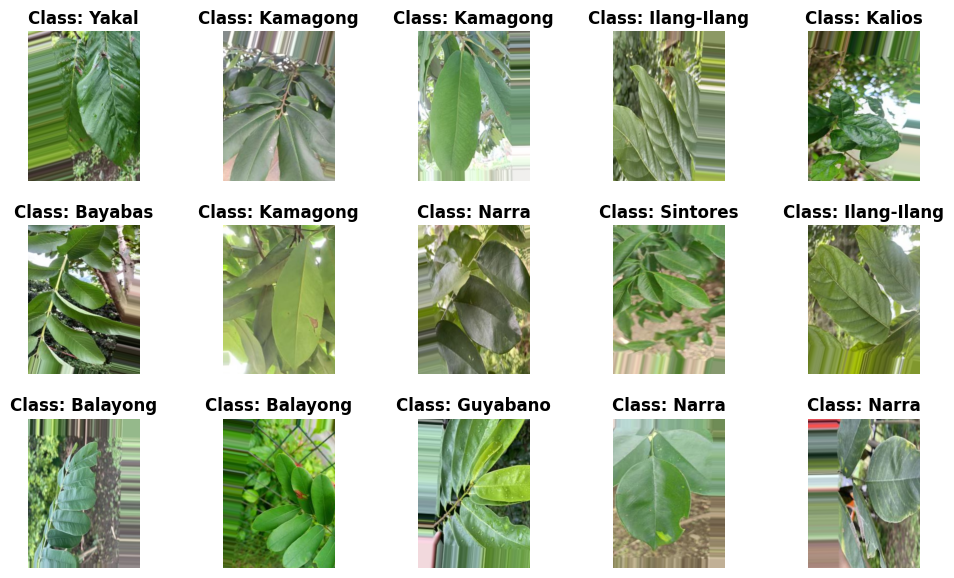

In [9]:
# Get the class indices and names from the train generator
class_indices = train_generator.class_indices
label_to_name = {idx: name for name, idx in class_indices.items()}
samples = train_generator.__next__()  # next fetches the image from the object. Each run gives a new set of images in the training set

images = samples[0]
target = samples[1]

plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])
    
    # Get the class index from one-hot encoded target
    label_idx = tuple(target[i]).index(1)
    class_name = label_to_name[label_idx]
    
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.show()

In [10]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()
#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=10)

# EarlyStopping callback to stop training if val_loss does not improve after n epochs
earlystop_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

### VGG16

In [11]:
# VGG16
input_layer=layers.Input(shape=(HEIGHT,WIDTH,CHANNELS))

# # Create the VGG16 model with your modifications
# base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)

# # Add custom dense layers with dropout and L2 regularization
# x = base_model.output
# x = layers.Flatten()(x)
# x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = layers.Dropout(0.3)(x)  # Add dropout
# x = layers.Dense(n_classes, activation='softmax')(x)

# model_vgg16 = models.Model(inputs=base_model.input, outputs=x)

model_vgg16=VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)
last_layer=model_vgg16.output
flatten=layers.Flatten()(last_layer) 
output_layer=layers.Dense(n_classes,activation='softmax')(flatten)
model_vgg16=models.Model(inputs=input_layer,outputs=output_layer)

print("We are making all the layers intrainable except the last layer. \n")
for layer in model_vgg16.layers[:-1]:
    layer.trainable=False

We are making all the layers intrainable except the last layer. 



In [12]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tfa.metrics.F1Score(num_classes=n_classes)]

CALLBACKS = [my_callback, rop_callback, earlystop_cb]

In [13]:
model_vgg16.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 225, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 225, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 225, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 56, 128)       0     

In [18]:
history_vgg = model_vgg16.fit(train_generator,batch_size=BATCH_SIZE,verbose=True,validation_data=test_generator, callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/5
70/70 [==============================] - 45s 643ms/step - loss: 0.4356 - acc: 0.8982 - f1_score: 0.8985 - val_loss: 0.6070 - val_acc: 0.8821 - val_f1_score: 0.8797 - lr: 0.0010
Epoch 2/5
70/70 [==============================] - 45s 646ms/step - loss: 0.3498 - acc: 0.9098 - f1_score: 0.9099 - val_loss: 0.4158 - val_acc: 0.9143 - val_f1_score: 0.9143 - lr: 0.0010
Epoch 3/5
70/70 [==============================] - 46s 657ms/step - loss: 0.3885 - acc: 0.9054 - f1_score: 0.9056 - val_loss: 0.6161 - val_acc: 0.8839 - val_f1_score: 0.8822 - lr: 0.0010
Epoch 4/5
70/70 [==============================] - 44s 625ms/step - loss: 0.4047 - acc: 0.9045 - f1_score: 0.9042 - val_loss: 0.6823 - val_acc: 0.8786 - val_f1_score: 0.8785 - lr: 0.0010
Epoch 5/5
70/70 [==============================] - 45s 643ms/step - loss: 0.3876 - acc: 0.9058 - f1_score: 0.9057 - val_loss: 0.5824 - val_acc: 0.8857 - val_f1_score: 0.8859 - lr: 0.0010


In [20]:
predictions = model_vgg16.predict(test_generator)

# Obtain the true labels from the test_generator
true_labels = test_generator.classes

# Generate the classification report
report = classification_report(true_labels, predictions.argmax(axis=1), target_names=class_names)
print(report)

18/18 [==============================] - 3s 178ms/step
              precision    recall  f1-score   support

    Balayong       1.00      0.80      0.89        40
     Bayabas       0.72      0.90      0.80        40
       Betis       0.98      1.00      0.99        40
         Dao       1.00      0.93      0.96        40
        Dita       0.83      0.97      0.90        40
    Guyabano       0.76      0.95      0.84        40
 Ilang-Ilang       0.86      0.75      0.80        40
        Ipil       0.93      1.00      0.96        40
      Kalios       1.00      0.90      0.95        40
    Kamagong       0.97      0.93      0.95        40
     Mulawin       0.70      0.80      0.74        40
       Narra       0.85      0.85      0.85        40
    Sintores       1.00      0.62      0.77        40
       Yakal       1.00      1.00      1.00        40

    accuracy                           0.89       560
   macro avg       0.90      0.89      0.89       560
weighted avg       0.90  

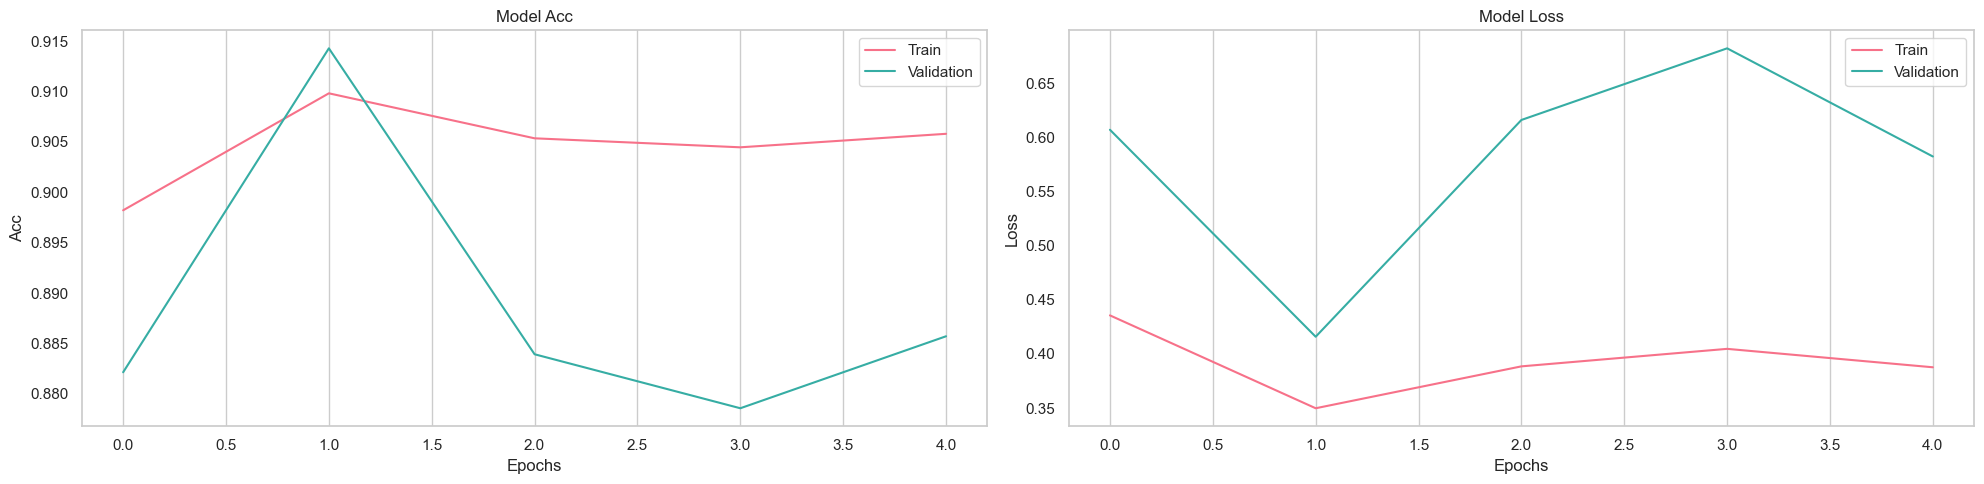

In [25]:
sns.set(style="whitegrid", rc={"axes.grid": True})

# Create a color palette
palette = sns.color_palette("husl", 2)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

# Loop through metrics
for i, metric in enumerate(["acc", "loss"]):
    sns.lineplot(x=history_vgg.epoch, y=history_vgg.history[metric], ax=ax[i], label="Train", color=palette[0])
    sns.lineplot(x=history_vgg.epoch, y=history_vgg.history["val_" + metric], ax=ax[i], label="Validation", color=palette[1])

    ax[i].set_title(f"Model {metric.capitalize()}")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric.capitalize())

    ax[i].legend().set_visible(True)

plt.tight_layout()
plt.savefig('../../server/vgg16/metrics/training')

plt.show()

In [22]:
model_path = '../../server/vgg16/artifacts/model.json'
model_json = model_vgg16.to_json()
with open(model_path, "w") as json_file:
  json_file.write(model_json)

# model_vgg16.save("vgg16_model.hdf5")

weights_path = '../../server/vgg16/artifacts/model_weights.hdf5'
model_vgg16.save_weights(weights_path)

### Inception V3

In [17]:
model_inception=InceptionV3(weights='imagenet')
input_layer=layers.Input(shape=(HEIGHT,WIDTH,CHANNELS))
model_inception=InceptionV3(weights='imagenet',input_tensor=input_layer,include_top=False)
last_layer=model_inception.output
flatten=layers.Flatten()(last_layer) 
output_layer=layers.Dense(n_classes,activation='softmax')(flatten)
model_inception=models.Model(inputs=input_layer,outputs=output_layer)

print("We are making all the layers intrainable except the last layer. \n")
for layer in model_inception.layers[:-1]:
    layer.trainable=False

We are making all the layers intrainable except the last layer. 



In [18]:
model_inception.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
model_inception.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 300, 225, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 149, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 149, 112, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                           

In [20]:
history_inception = model_inception.fit(train_generator,batch_size=BATCH_SIZE,verbose=True,validation_data=test_generator, callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/50
45/45 [==============================] - 28s 625ms/step - loss: 1.5205 - acc: 0.8687 - f1_score: 0.8684 - val_loss: 1.2126 - val_acc: 0.8806 - val_f1_score: 0.8816 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 27s 602ms/step - loss: 1.2478 - acc: 0.8757 - f1_score: 0.8760 - val_loss: 1.1116 - val_acc: 0.8861 - val_f1_score: 0.8855 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 27s 603ms/step - loss: 1.3402 - acc: 0.8757 - f1_score: 0.8756 - val_loss: 0.9858 - val_acc: 0.8833 - val_f1_score: 0.8838 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 27s 601ms/step - loss: 1.2719 - acc: 0.8681 - f1_score: 0.8678 - val_loss: 1.0489 - val_acc: 0.8861 - val_f1_score: 0.8872 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 27s 605ms/step - loss: 0.9710 - acc: 0.8924 - f1_score: 0.8926 - val_loss: 0.9598 - val_acc: 0.8972 - val_f1_score: 0.8967 - lr: 1.0000e-04
Epoch 6/50
45/45 [======================

In [21]:
predictions = model_inception.predict(test_generator)

# Obtain the true labels from the test_generator
true_labels = test_generator.classes

# Generate the classification report
report = classification_report(true_labels, predictions.argmax(axis=1), target_names=class_names)
print(report)

12/12 [==============================] - 3s 122ms/step
              precision    recall  f1-score   support

    Balayong       1.00      1.00      1.00        40
     Bayabas       0.87      0.85      0.86        40
         Dao       1.00      0.90      0.95        40
        Dita       1.00      0.93      0.96        40
      Kalios       0.90      0.93      0.91        40
    Kamagong       0.88      0.95      0.92        40
     Mulawin       0.84      0.93      0.88        40
       Narra       0.86      0.90      0.88        40
    Sintores       0.95      0.90      0.92        40

    accuracy                           0.92       360
   macro avg       0.92      0.92      0.92       360
weighted avg       0.92      0.92      0.92       360



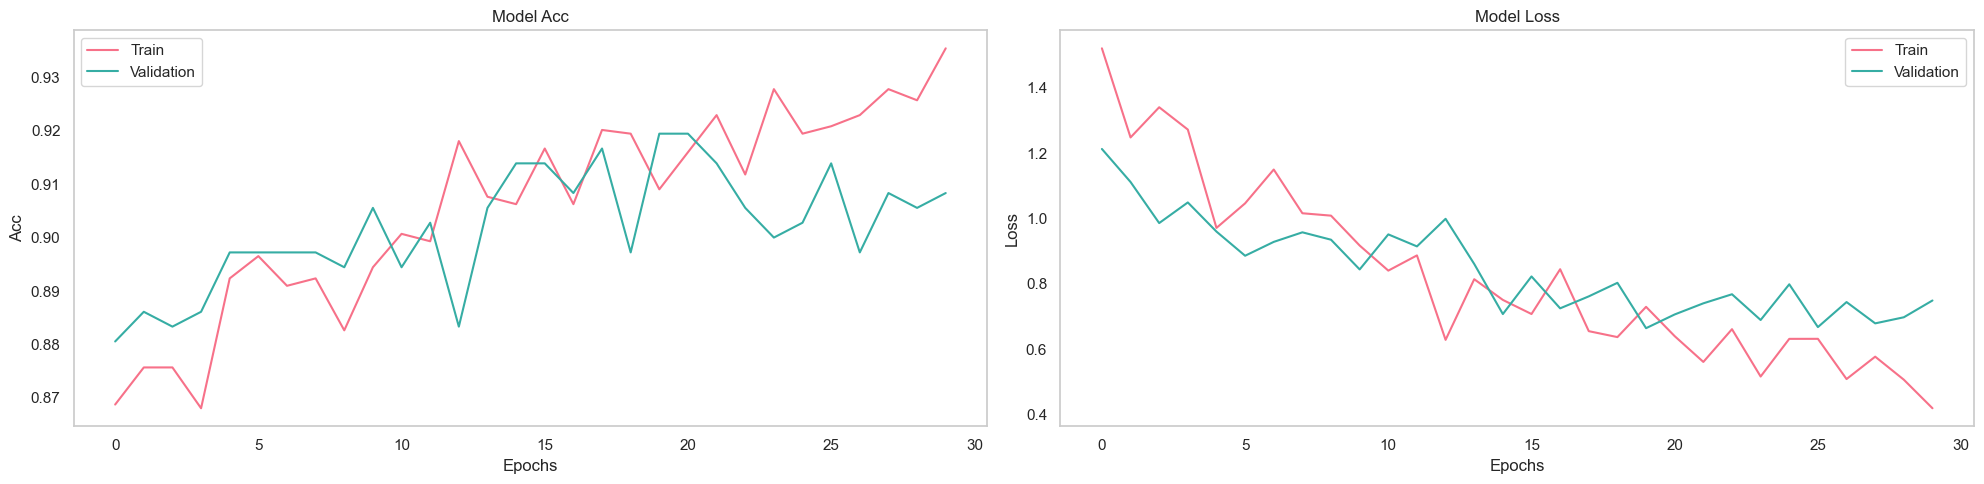

In [22]:
sns.set(style="whitegrid", rc={"axes.grid": False})

# Create a color palette
palette = sns.color_palette("husl", 2)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

# Loop through metrics
for i, metric in enumerate(["acc", "loss"]):
    sns.lineplot(x=history_inception.epoch, y=history_inception.history[metric], ax=ax[i], label="Train", color=palette[0])
    sns.lineplot(x=history_inception.epoch, y=history_inception.history["val_" + metric], ax=ax[i], label="Validation", color=palette[1])

    ax[i].set_title(f"Model {metric.capitalize()}")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric.capitalize())

    ax[i].legend().set_visible(True)

plt.tight_layout()
plt.savefig('../../server/inception/metrics/training')

plt.show()

In [23]:
model_path = '../../server/artifacts/inception/model.json'
model_json = model_inception.to_json()
with open(model_path, "w") as json_file:
  json_file.write(model_json)

weights_path = '../../server/artifacts/inception/model_weights.hdf5'
model_inception.save_weights(weights_path)

### ResNet50

In [21]:
model_inception=ResNet50(weights='imagenet')
input_layer=layers.Input(shape=(HEIGHT,WIDTH,CHANNELS))
model_resnet=ResNet50(weights='imagenet',input_tensor=input_layer,include_top=False)
last_layer=model_resnet.output
flatten=layers.Flatten()(last_layer) 
output_layer=layers.Dense(n_classes,activation='softmax')(flatten)
model_resnet=models.Model(inputs=input_layer,outputs=output_layer)

print("We are making all the layers intrainable except the last layer. \n")
for layer in model_resnet.layers[:-1]:
    layer.trainable=False

We are making all the layers intrainable except the last layer. 



In [22]:
model_resnet.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
model_resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300, 225, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 231, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 113, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [23]:
history_resnet = model_resnet.fit(train_generator,batch_size=BATCH_SIZE,verbose=True,validation_data=test_generator, callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/50
12/45 [=======>......................] - ETA: 18s - loss: 98.9535 - acc: 0.1094 - f1_score: 0.1020 

KeyboardInterrupt: 

In [28]:
predictions = model_resnet.predict(test_generator)

# Obtain the true labels from the test_generator
true_labels = test_generator.classes

# Generate the classification report
report = classification_report(true_labels, predictions.argmax(axis=1), target_names=class_names)
print(report)

12/12 [==============================] - 3s 116ms/step
              precision    recall  f1-score   support

    Balayong       1.00      1.00      1.00        40
     Bayabas       0.90      0.90      0.90        40
         Dao       0.92      0.88      0.90        40
        Dita       0.95      0.95      0.95        40
      Kalios       0.91      0.97      0.94        40
    Kamagong       0.93      0.93      0.93        40
     Mulawin       0.82      0.82      0.82        40
       Narra       0.95      0.90      0.92        40
    Sintores       0.88      0.90      0.89        40

    accuracy                           0.92       360
   macro avg       0.92      0.92      0.92       360
weighted avg       0.92      0.92      0.92       360



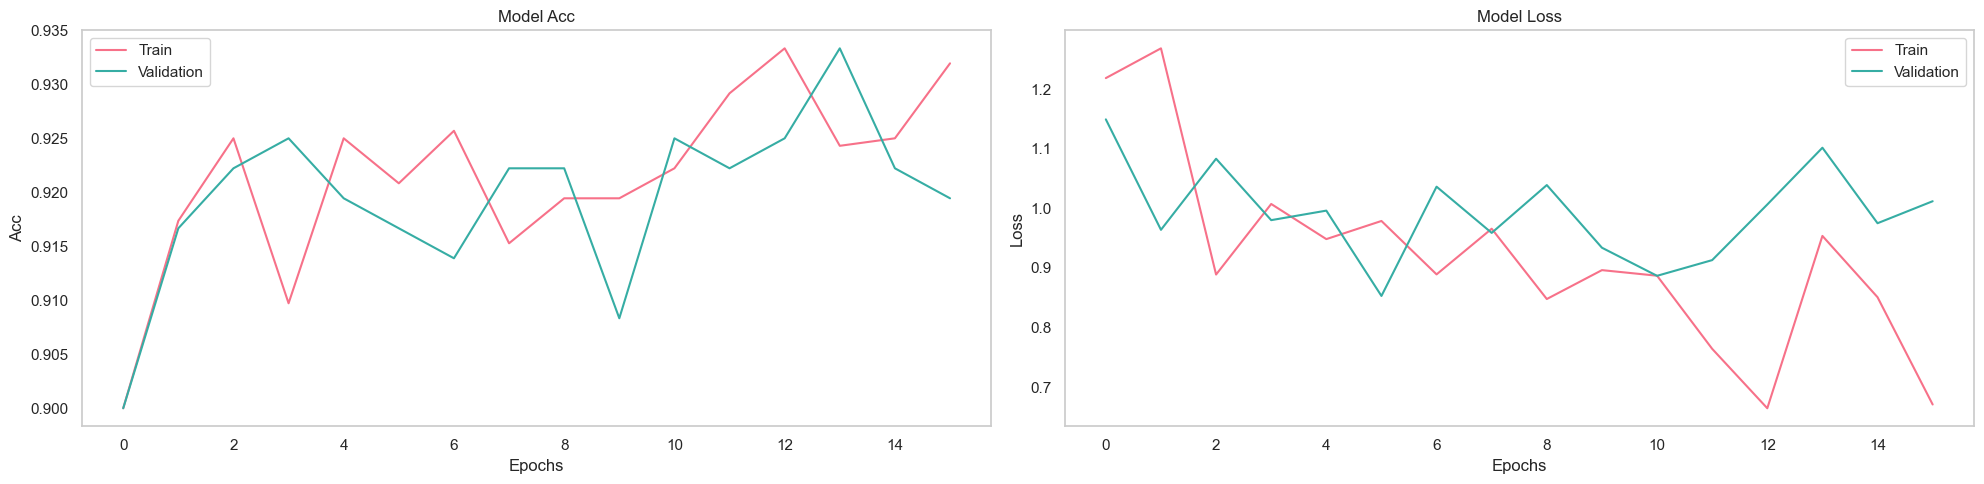

In [29]:
sns.set(style="whitegrid", rc={"axes.grid": False})

# Create a color palette
palette = sns.color_palette("husl", 2)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

# Loop through metrics
for i, metric in enumerate(["acc", "loss"]):
    sns.lineplot(x=history_resnet.epoch, y=history_resnet.history[metric], ax=ax[i], label="Train", color=palette[0])
    sns.lineplot(x=history_resnet.epoch, y=history_resnet.history["val_" + metric], ax=ax[i], label="Validation", color=palette[1])

    ax[i].set_title(f"Model {metric.capitalize()}")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric.capitalize())

    ax[i].legend().set_visible(True)

plt.tight_layout()
plt.savefig('../../server/resnet50/metrics/training')

plt.show()

In [30]:
model_path = '../../server/artifacts/resnet50/model.json'
model_json = model_resnet.to_json()
with open(model_path, "w") as json_file:
  json_file.write(model_json)

weights_path = '../../server/artifacts/resnet50/model_weights.hdf5'
model_resnet.save_weights(weights_path)

### Xception

In [24]:
model_xception=Xception(weights='imagenet')
input_layer=layers.Input(shape=(HEIGHT,WIDTH,CHANNELS))
model_xception=Xception(weights='imagenet',input_tensor=input_layer,include_top=False)
last_layer=model_xception.output
flatten=layers.Flatten()(last_layer) 
output_layer=layers.Dense(n_classes,activation='softmax')(flatten)
model_xception=models.Model(inputs=input_layer,outputs=output_layer)

print("We are making all the layers intrainable except the last layer. \n")
for layer in model_xception.layers[:-1]:
    layer.trainable=False

We are making all the layers intrainable except the last layer. 



In [25]:
model_xception.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
model_xception.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300, 225, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 112, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [27]:
history_xception = model_xception.fit(train_generator,batch_size=BATCH_SIZE,verbose=True,validation_data=test_generator, callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/50
45/45 [==============================] - 29s 640ms/step - loss: 1.0020 - acc: 0.8917 - f1_score: 0.8908 - val_loss: 1.5523 - val_acc: 0.8861 - val_f1_score: 0.8860 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 28s 630ms/step - loss: 0.7411 - acc: 0.9090 - f1_score: 0.9091 - val_loss: 1.5102 - val_acc: 0.8861 - val_f1_score: 0.8860 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 29s 633ms/step - loss: 0.7288 - acc: 0.8972 - f1_score: 0.8972 - val_loss: 1.4360 - val_acc: 0.8861 - val_f1_score: 0.8861 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 28s 628ms/step - loss: 0.8204 - acc: 0.9007 - f1_score: 0.9007 - val_loss: 1.3832 - val_acc: 0.8833 - val_f1_score: 0.8840 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 28s 630ms/step - loss: 0.7518 - acc: 0.9028 - f1_score: 0.9028 - val_loss: 1.3919 - val_acc: 0.8833 - val_f1_score: 0.8832 - lr: 1.0000e-04
Epoch 6/50
45/45 [======================

In [28]:
predictions = model_xception.predict(test_generator)

# Obtain the true labels from the test_generator
true_labels = test_generator.classes

# Generate the classification report
report = classification_report(true_labels, predictions.argmax(axis=1), target_names=class_names)
print(report)

12/12 [==============================] - 3s 186ms/step
              precision    recall  f1-score   support

    Balayong       0.90      0.95      0.93        40
     Bayabas       0.90      0.90      0.90        40
         Dao       1.00      0.93      0.96        40
        Dita       0.93      0.97      0.95        40
      Kalios       0.95      0.93      0.94        40
    Kamagong       0.86      0.93      0.89        40
     Mulawin       0.84      0.90      0.87        40
       Narra       0.90      0.90      0.90        40
    Sintores       0.94      0.80      0.86        40

    accuracy                           0.91       360
   macro avg       0.91      0.91      0.91       360
weighted avg       0.91      0.91      0.91       360



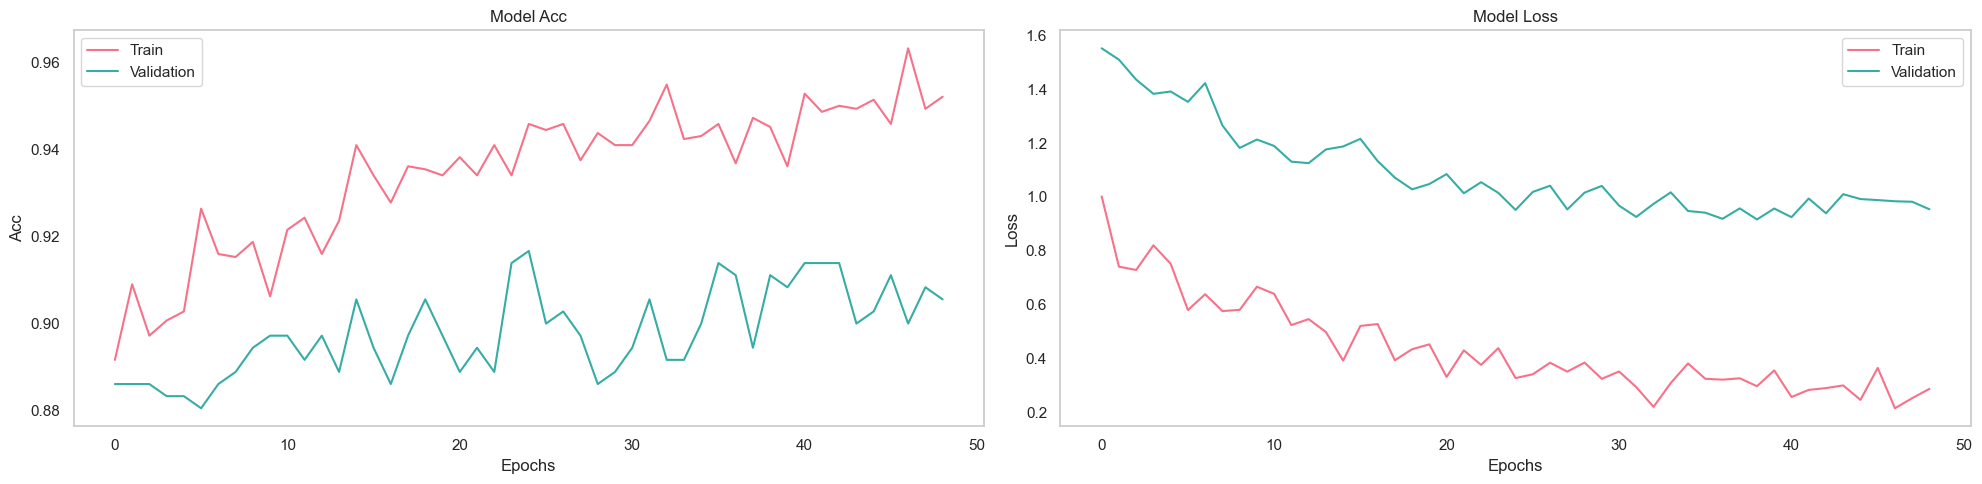

In [29]:
sns.set(style="whitegrid", rc={"axes.grid": False})

# Create a color palette
palette = sns.color_palette("husl", 2)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

# Loop through metrics
for i, metric in enumerate(["acc", "loss"]):
    sns.lineplot(x=history_xception.epoch, y=history_xception.history[metric], ax=ax[i], label="Train", color=palette[0])
    sns.lineplot(x=history_xception.epoch, y=history_xception.history["val_" + metric], ax=ax[i], label="Validation", color=palette[1])

    ax[i].set_title(f"Model {metric.capitalize()}")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric.capitalize())

    ax[i].legend().set_visible(True)

plt.tight_layout()
plt.savefig('../../server/xception/metrics/training')

plt.show()

In [30]:
model_path = '../../server/artifacts/xception/model.json'
model_json = model_xception.to_json()
with open(model_path, "w") as json_file:
  json_file.write(model_json)

weights_path = '../../server/artifacts/xception/model_weights.hdf5'
model_xception.save_weights(weights_path)